# Convolutional Neural Network (CNN)

### Import TensorFlow

'20211201-1636'

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models


In [8]:
import os,json, imageio, pickle
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from os.path import join as pj
datetime_str = datetime.now().strftime("%Y%m%d-%H%S")


RUNTIME_DATA_DIR =pj('datasource','runtime', 'anim_repo')
RUNTIME_SRC_TAGS =pj('datasource' ,'runtime', 'src_tags.json')

# if exceed (N_LABEL-1) labels, belong to 0
N_LABEL = 128
N_RECOMMEND_LABEL = 10
resize_shape = (50,50,3)

save tag_count_plot.svg
save tag_count_plot_no_gender_.svg


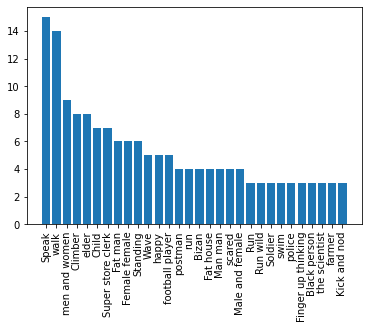

In [9]:
    
### prepare training data
def get_train_pairs(src_tags ):
    tk_tag_to_idx, tk_idx_to_tag = get_tks(src_tags)
    x,y=[],[]
    for src,tags in src_tags.items():
        img = imageio.imread(src)
        img_resized = np.resize(img,  resize_shape)
        for tag in tags:
            
            if tag not in tk_tag_to_idx:
                idx=0
            else:
                idx=tk_tag_to_idx[tag]
            
            x.append(img_resized)
            y.append(idx)

    x,y= np.array(x), np.array(y)
    x=x/255.0
    y=y.reshape((-1,1))
    return x,y,tk_tag_to_idx, tk_idx_to_tag

def get_tks(src_tags):
    global try_tag_count
    """
    limit tag to N_LABEL-1
    tk_tag_to_idx, tk_idx_to_tag
    """
    all_token = []
    tk_tag_to_idx = {'NULL':0}
    tk_idx_to_tag = {0:'NULL'}
    for src, tags in src_tags.items():
        for tag in tags:
            all_token.append(tag)
    
    tag_set_descending = sorted([[tag,count] 
                        for tag,count in Counter(all_token).items()],
                        key = lambda x:-x[1])
    if len(tag_set_descending)>N_LABEL-1:
        # remain the (N_LABEL-1) most frequent tag
        # e.g. (n=128, len(tag_set)=128)
        #  current len(tag_set)=127
        #  `0` is used to store OTHER TAGs
        tag_set_descending=tag_set_descending[:N_LABEL-1] 
        
    # save plot, with and without gender
    save_tag_count_diagram(tag_set_descending, True)
    save_tag_count_diagram(tag_set_descending, False)
    
    # initialize tokenizers (bidirections)
    for i in range(len(tag_set_descending)):
        tag,freq = tag_set_descending[i]
        tk_tag_to_idx[tag]=i+1
        tk_idx_to_tag[i+1]=tag
    
    return tk_tag_to_idx, tk_idx_to_tag


def save_tag_count_diagram(tag_count,
                           include_gender=True,
                           top_n=30):
    fn='tag_count_plot' + \
        ('' if include_gender else '_no_gender_') + \
        '.svg'
    
    if not include_gender:
        tag_count = [t for t in tag_count 
                     if 'male' != t[0].lower() and 'female' != t[0].lower()]
    top_n = top_n if len(tag_count)>=top_n else len(tag_count)

    tags = [t[0] for t in tag_count[:top_n]]
    tags_idx=range(len(tags))
    counts = [t[1] for t in tag_count[:top_n]]
    plt.clf()
    plt.bar(x=tags_idx,height=counts)
    plt.xticks(tags_idx , tags, rotation=90)
    plt.savefig(fn,pad_inches=0.8,bbox_inches="tight")
    print(f'save {fn}')


### main architecture
with open(RUNTIME_SRC_TAGS, 'r' , encoding='utf-8') as f:
    src_tags = json.load(f)

x,y,tk_tag_to_idx,tk_idx_to_tag = get_train_pairs(src_tags)

In [10]:
def train(x,y):
#    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=resize_shape))
    model = models.Sequential()
#     model.add(layers.Flatten(input_shape=resize_shape))
#     model.add(layers.Dense(np.prod(resize_shape)))
#     model.add(layers.Reshape(resize_shape)) # reshape to 32x32x3
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=resize_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(N_LABEL))
    model.summary()
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(x,y, 
                        epochs=200, 
                        validation_split=0.1,
                        verbose=2)
    return history,model

history , model = train(x,y)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

Epoch 69/200
23/23 - 1s - loss: 2.9246 - accuracy: 0.2306 - val_loss: 3.9176 - val_accuracy: 0.2750
Epoch 70/200
23/23 - 1s - loss: 2.9228 - accuracy: 0.2181 - val_loss: 4.0419 - val_accuracy: 0.2625
Epoch 71/200
23/23 - 1s - loss: 2.9110 - accuracy: 0.2389 - val_loss: 3.9900 - val_accuracy: 0.2375
Epoch 72/200
23/23 - 1s - loss: 2.9154 - accuracy: 0.2347 - val_loss: 3.8111 - val_accuracy: 0.2625
Epoch 73/200
23/23 - 1s - loss: 2.9104 - accuracy: 0.2333 - val_loss: 3.9069 - val_accuracy: 0.2625
Epoch 74/200
23/23 - 1s - loss: 2.9163 - accuracy: 0.2292 - val_loss: 3.9154 - val_accuracy: 0.2375
Epoch 75/200
23/23 - 1s - loss: 2.9053 - accuracy: 0.2361 - val_loss: 3.9592 - val_accuracy: 0.2625
Epoch 76/200
23/23 - 1s - loss: 2.8944 - accuracy: 0.2236 - val_loss: 3.9915 - val_accuracy: 0.2375
Epoch 77/200
23/23 - 1s - loss: 2.9154 - accuracy: 0.2222 - val_loss: 4.0534 - val_accuracy: 0.2500
Epoch 78/200
23/23 - 1s - loss: 2.9212 - accuracy: 0.2125 - val_loss: 3.8310 - val_accuracy: 0.2375


Epoch 151/200
23/23 - 1s - loss: 2.7467 - accuracy: 0.2347 - val_loss: 4.3013 - val_accuracy: 0.2500
Epoch 152/200
23/23 - 1s - loss: 2.7406 - accuracy: 0.2417 - val_loss: 4.1685 - val_accuracy: 0.2500
Epoch 153/200
23/23 - 1s - loss: 2.7554 - accuracy: 0.2361 - val_loss: 4.2793 - val_accuracy: 0.2000
Epoch 154/200
23/23 - 1s - loss: 2.7408 - accuracy: 0.2444 - val_loss: 4.3825 - val_accuracy: 0.2500
Epoch 155/200
23/23 - 1s - loss: 2.7522 - accuracy: 0.2208 - val_loss: 4.2732 - val_accuracy: 0.2500
Epoch 156/200
23/23 - 1s - loss: 2.7582 - accuracy: 0.2472 - val_loss: 4.2609 - val_accuracy: 0.2500
Epoch 157/200
23/23 - 1s - loss: 2.7434 - accuracy: 0.2347 - val_loss: 4.2367 - val_accuracy: 0.2625
Epoch 158/200
23/23 - 1s - loss: 2.7581 - accuracy: 0.2361 - val_loss: 4.2824 - val_accuracy: 0.2500
Epoch 159/200
23/23 - 1s - loss: 2.7270 - accuracy: 0.2528 - val_loss: 4.2386 - val_accuracy: 0.2625
Epoch 160/200
23/23 - 1s - loss: 2.7325 - accuracy: 0.2431 - val_loss: 4.2603 - val_accurac

In [11]:




def save_model(model, pickle_fn , tk_tag_to_idx,  tk_idx_to_tag):
    model.save('saved_model/tag_recommend.model')
    with open(pickle_fn , 'wb') as f:
        pickle.dump([tk_tag_to_idx,tk_idx_to_tag], f)
    
def load_model(model_dir ='saved_model/tag_recommend.model',
               pickle_fn = 'tokenizers.pickle'):
    model=tf.keras.models.load_model(model_dir)
    with open(pickle_fn, 'rb') as f:
        [tk_tag_to_idx, tk_idx_to_tag] = pickle.load(f)
    return model, tk_tag_to_idx, tk_idx_to_tag
        

In [12]:
save_model(model,
           pickle_fn = 'tokenizers.pickle',
           tk_tag_to_idx = tk_tag_to_idx,
           tk_idx_to_tag = tk_idx_to_tag)

model_ld,tk_tti,tk_itt = load_model()


INFO:tensorflow:Assets written to: saved_model/tag_recommend.model/assets


In [5]:
# model,tk_tag_to_idx, tk_idx_to_tag = load_model()

In [13]:
def pred_tags(model, src):
    img=imageio.imread(src)
    x = np.resize(img,  resize_shape)
    x = np.array([x])/255.0
    recommend_tags_logit=model.predict(x)
    recommend_tags_sorted=sorted(list(
            zip(range(N_LABEL),recommend_tags_logit[0].tolist())
        ), key=lambda x:-x[1])
    recommend_tags_idx = [t[0] for t in recommend_tags_sorted[:N_RECOMMEND_LABEL]]
    recommend_tags = [tk_idx_to_tag[t] for t in recommend_tags_idx]
    return recommend_tags
for i,src in enumerate(src_tags.keys()):
    if not (set(pred_tags(model, src)) == set( pred_tags(model_ld,src))):
        print(i)
        break
print('test ok')        

test ok


In [7]:
set(pred_tags(model_ld,src))

{'Climber',
 'Fat man',
 'Female',
 'Handsome',
 'NULL',
 'Speak',
 'Wave',
 'male',
 'men and women',
 'walk'}

In [229]:
set(pred_tags(model,src))
# model_ld

{'Climber',
 'Fat man',
 'Female',
 'NULL',
 'Run',
 'Speak',
 'Wave',
 'male',
 'men and women',
 'walk'}

In [201]:
src_tags

{'datasource/runtime/anim_repo/baker wave.gif': ['male', 'Baker', 'Wave'],
 'datasource/runtime/anim_repo/amy_run_gif.gif': ['Female', 'Run'],
 'datasource/runtime/anim_repo/amy_run_sad_gif.gif': ['Female', 'Run', 'sad'],
 'datasource/runtime/anim_repo/boy talk.gif': ['male', 'Speak'],
 'datasource/runtime/anim_repo/boy walk2.gif': ['male', 'walk'],
 'datasource/runtime/anim_repo/boy walk.gif': ['male', 'walk'],
 'datasource/runtime/anim_repo/boy_run.gif': ['male', 'Run wild'],
 'datasource/runtime/anim_repo/boy_speak_gif.gif': ['male',
  'Fat man',
  'Speak'],
 'datasource/runtime/anim_repo/boy_speak_gif2.gif': ['male',
  'Fat man',
  'Speak',
  'happy'],
 'datasource/runtime/anim_repo/boy_walk.gif': ['male', 'Child', 'walk'],
 'datasource/runtime/anim_repo/chef wave .gif': ['male', 'chef', 'Wave'],
 'datasource/runtime/anim_repo/girl run .gif': ['men and women',
  'Female running',
  'Crying'],
 'datasource/runtime/anim_repo/girl talk.gif': ['Female', 'Waved to speak'],
 'datasource/